# Olympus Growth Analysis 
### samsar#6017 

In [1]:
import asyncio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport

# Olympus SubGraph Data Query

In [2]:
"""
Query Olympus DAO Subgraph 

Sources: [https://github.com/graphql-python/gql,https://thegraph.com/hosted-service/subgraph/drondin/olympus-protocol-metrics]
Note: Some historical data may not be completely accurate due to different contract versions
"""

async def main():
    transport = AIOHTTPTransport(url="https://api.thegraph.com/subgraphs/name/drondin/olympus-protocol-metrics")
    # Using `async with` on the client will start a connection on the transport
    # and provide a `session` variable to execute queries on this connection
    async with Client(
        transport=transport, fetch_schema_from_transport=True,
    ) as session:
        # Execute single query
        query = gql(
            """
              query {
                  protocolMetrics(first: 1000, orderBy: timestamp, orderDirection: desc) {
                    timestamp
                    ohmPrice
                    marketCap
                    ohmCirculatingSupply
                    sOhmCirculatingSupply
                    totalSupply
                    totalValueLocked
                    treasuryMarketValue
                    treasuryRiskFreeValue
                    currentAPY
                  }
                  rebases(first: 1000, orderBy: timestamp, orderDirection: desc){
                    timestamp
                    amount
                    stakedOhms
                    percentage
                    value
                  }
                  dailyBonds(first: 1000, orderBy: timestamp, orderDirection: desc){
                    timestamp
                    token {
                      id
                    }
                    amount
                    value
                  }
                }
        """
        )
        query_results = await session.execute(query)
        return query_results
        
query_results = await main()

In [3]:
"""
Utils
"""

def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame


In [4]:
"""
Pre-Process Data
""" 

# convert unix timestamp to datetime | clean up formatting | filter all data before 4/15
protocol_metrics_df = pd.DataFrame(query_results['protocolMetrics'])
protocol_metrics_df['timestamp'] = pd.to_datetime(protocol_metrics_df['timestamp'], unit='s')
# 5/29 is an outier -> remove data point
protocol_metrics_df = protocol_metrics_df[(protocol_metrics_df['timestamp'] >= '2021-04-15') & (protocol_metrics_df['timestamp'] != '2021-05-29 03:49:55')]

rebases_df = pd.DataFrame(query_results['rebases'])
rebases_df['timestamp'] = pd.to_datetime(rebases_df['timestamp'], unit='s')
rebases_df['percentage'] = rebases_df['percentage'].apply(lambda x: float(x)*100)
rebases_df = rebases_df[rebases_df['timestamp'] >= '2021-04-15']

daily_bond_df = pd.DataFrame(query_results['dailyBonds'])
daily_bond_df['timestamp'] = pd.to_datetime(daily_bond_df['timestamp'], unit='s')
daily_bond_df['token'] = daily_bond_df['token'].apply(lambda x: x['id'])
daily_bond_df = daily_bond_df[daily_bond_df['timestamp'] >= '2021-04-15']

In [5]:
protocol_metrics_df.head(5)

,currentAPY,marketCap,ohmCirculatingSupply,ohmPrice,sOhmCirculatingSupply,timestamp,totalSupply,totalValueLocked,treasuryMarketValue,treasuryRiskFreeValue
0,7339.020071683315,2680971252.86442031551717777139766,5729683.651758709,467.909123052806646597687683292338,5050157.426281722,2021-12-08 00:00:26,6698648.60321498,2363014732.610099570422152882300331,713269262.3120883687438480737932823,188503239.3589924843127529497675329
1,7181.78741376668,3026959611.225590379735423544549595,5685668.189018813,532.3841474027274856102820727519611,5041856.280345267,2021-12-07 00:01:50,6653850.546843945,2684204357.138701939874107811850097,742885210.1374139338683517603020743,188095975.1726882808455063533273541
2,7168.41483348686,3202976249.504480578080813602897977,5617366.853604534,570.191752288566487416982191174303,4987673.607735004,2021-12-06 00:00:12,6583017.456141181,2843930354.237858135853485201026531,757748652.487902310560455526657591,186862384.8029918311051341269956865
3,7186.887952202917,3190043142.937326879353419030241969,5549831.240875593,574.8000262498136790136461737876868,4933980.931298053,2021-12-05 00:03:08,6512845.556362797,2836052368.826201006780120826720613,751644696.9804208252535053737056407,185576041.8257602115611153074848796
4,7171.810599830789,3180763080.807852752404520132804697,5481853.873472738,580.2349267644467278188152308650723,4880512.568590595,2021-12-04 00:01:25,6443106.792075965,2831843852.80912567725865137632296,746161750.0828820798517542662098387,184519237.4615862178927383857344529


# Token Dilution 

## Supply Growth

<AxesSubplot:title={'center':'% Growth Rate v Initial Supply'}, xlabel='timestamp'>

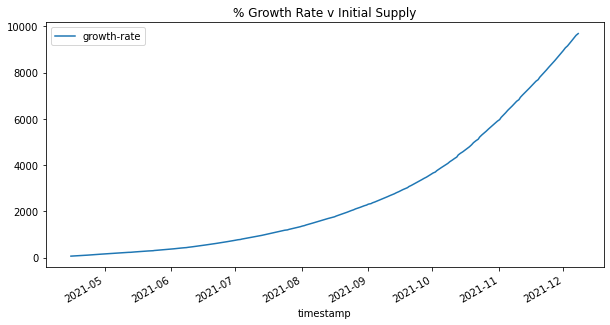

In [6]:
# calculate supply growth -> initial supply for Ohm = 58518.017977429 [https://dune.xyz/queries/29030/58580]
supply_growth_df = select_columns(protocol_metrics_df, ['timestamp', 'ohmCirculatingSupply'])
supply_growth_df['ohmCirculatingSupply'] = supply_growth_df['ohmCirculatingSupply'].apply(lambda x: ((float(x)-58518.017977429)/58518.017977429)*100)
supply_growth_df.columns = ['timestamp', "growth-rate"]

supply_growth_df.plot(x="timestamp", y="growth-rate",title="% Growth Rate v Initial Supply", figsize=(10,5))

## Index 

<AxesSubplot:title={'center':'Index'}, xlabel='timestamp'>

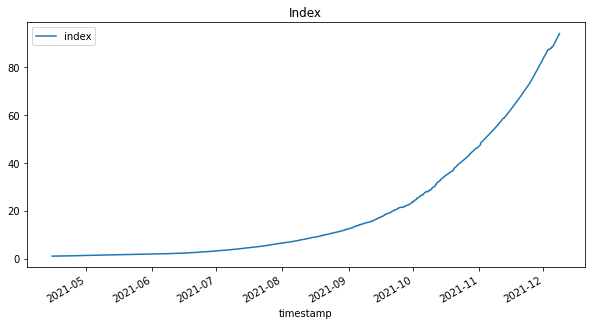

In [7]:
# calculate index --> results are slightly off - Ohm index should be ~43 
index_df = select_columns(rebases_df, ['timestamp', 'percentage'])

index = []
cur_index = 1
for value in rebases_df["percentage"]:
    if value > 1:
        index.insert(0, cur_index)
        continue
    cur_index = cur_index*(value/100 + 1)
    index.insert(0, cur_index)
       
index_df["index"] = index

index_df.plot(x="timestamp", y="index",title="Index", figsize=(10,5))

# Dilution

Text(0, 0.5, '% Dilution')

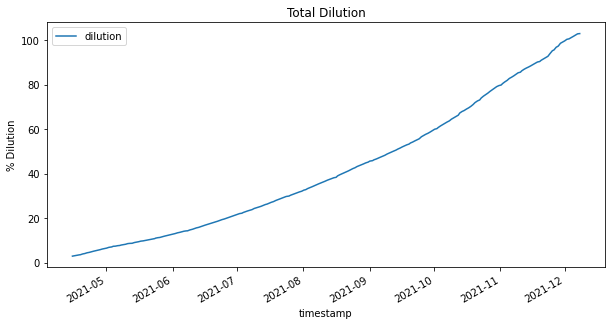

In [8]:
dilution_df = select_columns(supply_growth_df, ['timestamp', 'growth-rate'])
dilution_df['growth-rate'] = dilution_df['growth-rate']/index_df["index"]
dilution_df.columns = ['timestamp', "dilution"]

dilution_df.plot(x="timestamp", y="dilution",title="Total Dilution", figsize=(10,5))
plt.ylabel('% Dilution')

# Treasury Managament

## Treasury RFV / Market Value

<AxesSubplot:title={'center':'% Growth Rate v Initial Supply'}, xlabel='timestamp'>

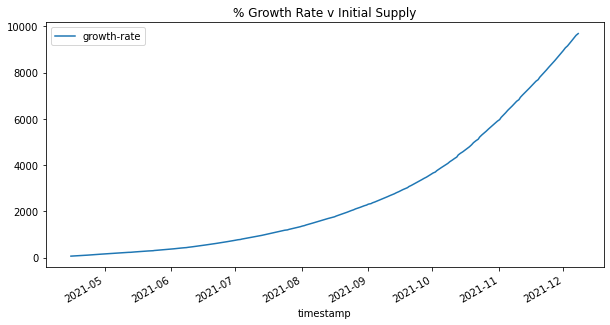

In [9]:
# calculate supply growth -> initial supply for Ohm = 58518.017977429 [https://dune.xyz/queries/29030/58580]
supply_growth_df = select_columns(protocol_metrics_df, ['timestamp', 'ohmCirculatingSupply'])
supply_growth_df['ohmCirculatingSupply'] = supply_growth_df['ohmCirculatingSupply'].apply(lambda x: ((float(x)-58518.017977429)/58518.017977429)*100)
supply_growth_df.columns = ['timestamp', "growth-rate"]

supply_growth_df.plot(x="timestamp", y="growth-rate",title="% Growth Rate v Initial Supply", figsize=(10,5))

## Debt Ratio 

<AxesSubplot:title={'center':'% Debt Ratio'}, xlabel='timestamp'>

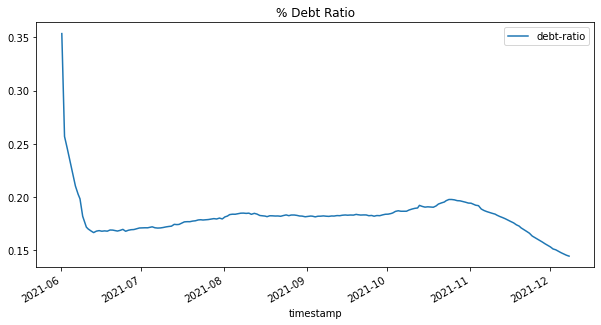

In [10]:
# filter the data to start after July
debt_ratio_df = select_columns(protocol_metrics_df[protocol_metrics_df['timestamp'] >= '2021-06-01'], ['timestamp', 'ohmCirculatingSupply'])
debt_ratio_df['ohmCirculatingSupply'] = (pd.to_numeric(protocol_metrics_df['totalSupply'])-pd.to_numeric(protocol_metrics_df['ohmCirculatingSupply']))/pd.to_numeric(protocol_metrics_df['totalSupply'])
debt_ratio_df.columns = ['timestamp', "debt-ratio"]

debt_ratio_df.plot(x="timestamp", y="debt-ratio",title="% Debt Ratio", figsize=(10,5))

## Ohm Price

<AxesSubplot:title={'center':'Ohm Price'}, xlabel='timestamp'>

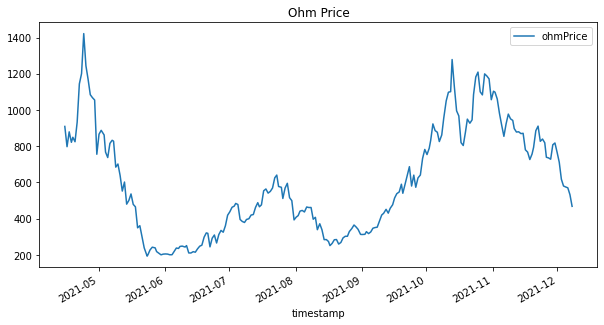

In [11]:
price_df = select_columns(protocol_metrics_df, ['timestamp', 'ohmPrice'])
price_df['ohmPrice'] = price_df['ohmPrice'].apply(lambda x: float(x))
price_df.plot(x="timestamp", y="ohmPrice", title="Ohm Price",figsize=(10,5))